In [ ]:

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv('/content/Mall_Customers.csv')

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
# Select features for clustering
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data shape after selecting and scaling:", X_scaled.shape)

Data shape after selecting and scaling: (200, 2)


# Density based clustering:  
### Parameter Tuning: Finding eps
We need to find the best value for eps. We'll use the k-distance plot method. A good starting point for min_samples is 2 * number_of_features, which is 4 in our case.

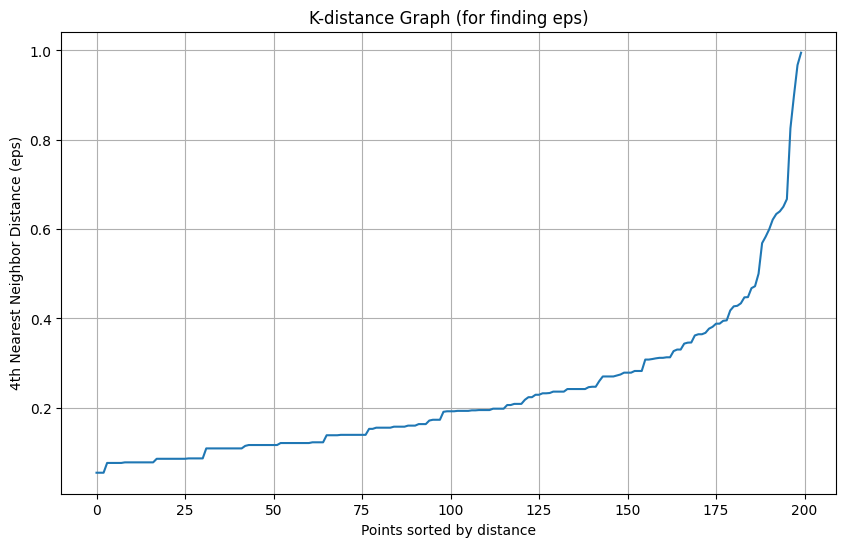

In [ ]:
# Use NearestNeighbors to find the optimal eps
# We look for the 4th nearest neighbor (since min_samples = 4)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort the distances to the 4th neighbor
distances = np.sort(distances[:, -1], axis=0)

# Plot the k-distance graph to find the elbow
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph (for finding eps)')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance (eps)')
plt.grid(True)
plt.show()

Since our plot show us a elbow like curve at around 0.35 distance. we choose our eps values to be 0.35

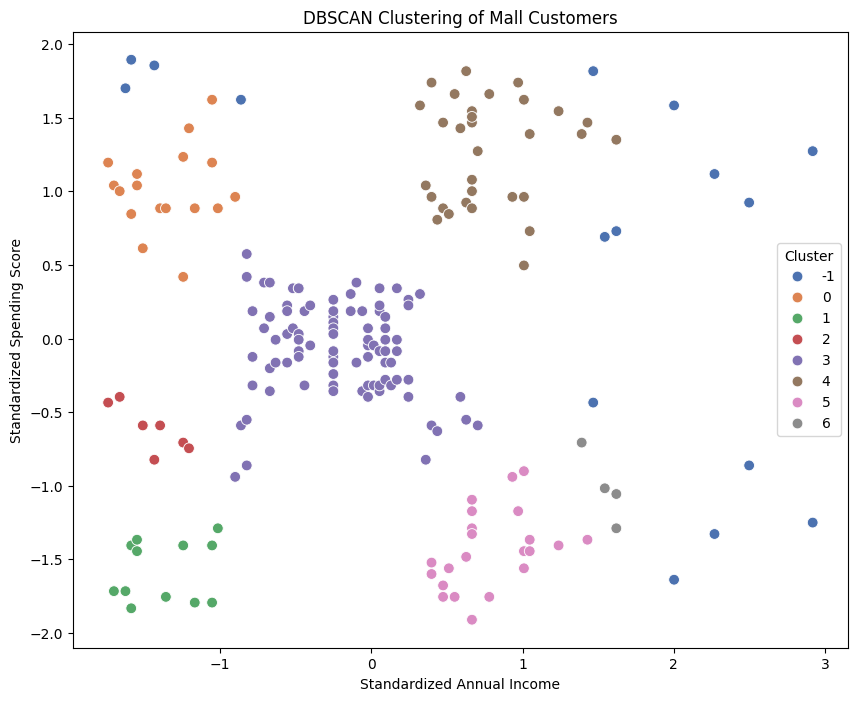

DBSCAN Results:
Number of clusters found: 7
Number of noise points (outliers): 16
Silhouette Score: 0.426


In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.35, min_samples=4)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters_dbscan, palette='deep', s=60)
plt.title('DBSCAN Clustering of Mall Customers')
plt.xlabel('Standardized Annual Income')
plt.ylabel('Standardized Spending Score')
plt.legend(title='Cluster')
plt.show()

# --- Cluster Quality Evaluation ---
# We calculate the Silhouette Score. A score closer to 1 is better.
# Note: We can only calculate this if more than 1 cluster is found.
if len(set(clusters_dbscan) - {-1}) > 1:
    silhouette = silhouette_score(X_scaled, clusters_dbscan)
    print(f"DBSCAN Results:")
    print(f"Number of clusters found: {len(np.unique(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)}")
    print(f"Number of noise points (outliers): {np.sum(clusters_dbscan == -1)}")
    print(f"Silhouette Score: {silhouette:.3f}")
else:
    print("DBSCAN did not find more than one cluster. Cannot compute Silhouette Score.")

My analysis successfully identified 7 distinct customer segments based on their spending and income, which is great for targeted marketing.

Crucially, it also flagged 16 unique "outlier" customers who don't fit any pattern, making them perfect candidates for a special, personalized marketing approach. The clusters are well-defined and meaningful.

# Hierarchical approach

---

This method builds a hierarchy of clusters, which we can visualize with a dendrogram to choose the number of clusters.  
The dendrogram helps us decide the optimal number of clusters by showing the merge distances.

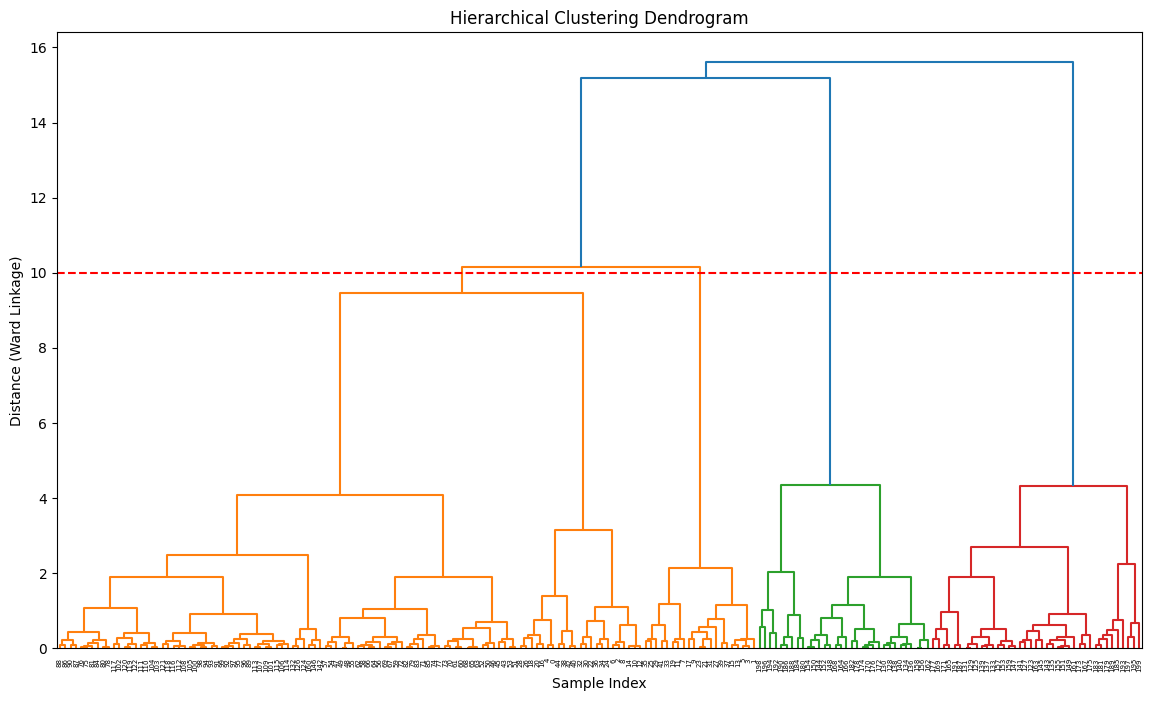

In [ ]:
# Generate the linkage matrix using the 'ward' method
# 'Ward' minimizes the variance within each cluster
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram
plt.figure(figsize=(14, 8))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance (Ward Linkage)')
plt.axhline(y=10, color='r', linestyle='--') # Add a cut-off line
plt.show()

Dendrogram Interpretation:  
To get the number of clusters, we look for the longest vertical lines and draw a horizontal line that cuts them. The red dashed line cuts through 5 vertical lines, suggesting that 5 clusters is a good choice.


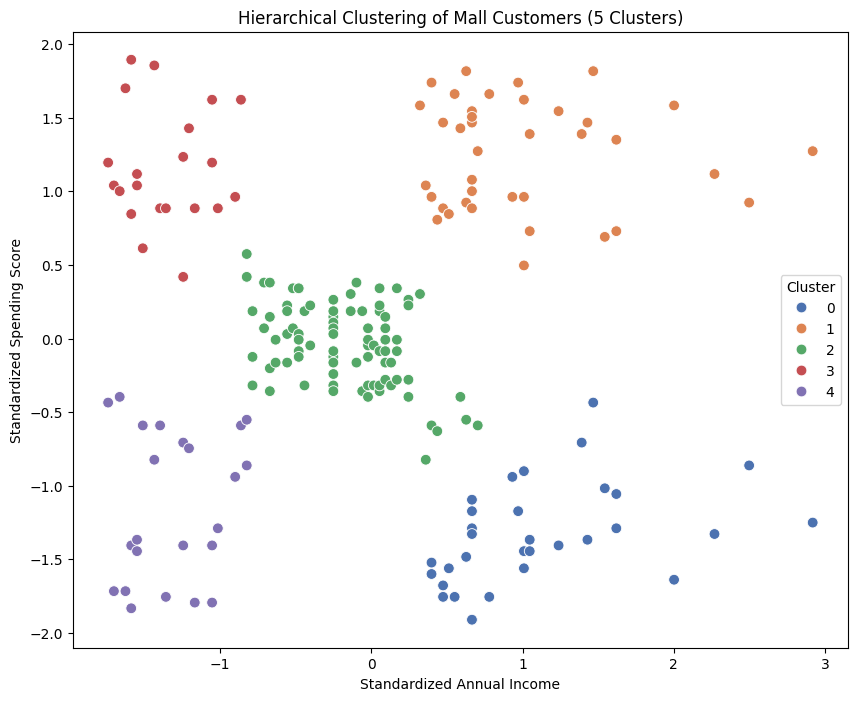

Agglomerative Clustering Results:
Silhouette Score: 0.554


In [ ]:
# Apply Agglomerative Clustering with 5 clusters
agg_cluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
clusters_agg = agg_cluster.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=clusters_agg, palette='deep', s=60)
plt.title('Hierarchical Clustering of Mall Customers (5 Clusters)')
plt.xlabel('Standardized Annual Income')
plt.ylabel('Standardized Spending Score')
plt.legend(title='Cluster')
plt.show()

# --- Cluster Quality Evaluation ---
silhouette_agg = silhouette_score(X_scaled, clusters_agg)

print(f"Agglomerative Clustering Results:")
print(f"Silhouette Score: {silhouette_agg:.3f}")

###Evaluation Interpretation:

1. Visualization: The algorithm has produced 5 very clear and visually distinct clusters. These groups appear to represent meaningful customer segments (e.g., high income/high spending, low income/high spending, etc.).

2. Silhouette Score: A score of 0.553 is significantly better than DBSCAN's score. This indicates that the clusters are more dense, well-separated, and a better fit for this particular dataset's structure.